The dataset is 519 observations of forest fires in Portugal. What we are trying to predict is the x and y spatial coordinates of the forest fires given a number of features, such as the temperature, wind, rain, etc. The dataset can be found here: https://archive.ics.uci.edu/dataset/162/forest+fires

In [30]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from importlib import reload
from forestFireCode.models import feedforwardnet as ff
from forestFireCode.models.feedforwardnet import NNregressor
import sklearn as sk
from sklearn.model_selection import train_test_split

In [2]:
forest_data = pd.read_csv('Downloads/forestfirestuff/forestfires.csv')

In [3]:
forest_data.shape

(517, 13)

In [4]:
colNames = ['month', 'day']

Next, we one-hot encode the categorical variables.

In [5]:
for col in colNames:
    if( forest_data[col].dtype == np.dtype('object')):
        dummies = pd.get_dummies(forest_data[col],prefix=col)
        forest_data = pd.concat([forest_data,dummies],axis=1)

        #drop the encoded column
        forest_data.drop([col],axis = 1 , inplace=True)

In [6]:
forest_data.fillna(forest_data.mean())

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,1,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,1,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,1,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,1,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
train, test = train_test_split(forest_data, train_size = 0.8)

In [18]:
y_train = train[['X', 'Y']]
X_train = train.drop(['X', 'Y'], axis = 1)

In [19]:
reload(ff)

<module 'forestFireCode.models.feedforwardnet' from '/Users/samdulin/forestFireCode/models/feedforwardnet.py'>

The first model we are going to try out is a feed forward neural network with many layers.

In [20]:
nn = ff.NNregressor()

In [21]:
nn.fit(X_train = X_train, 
              y_train = y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3712      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
Total params: 168,834
Trainable params: 168,834
Non-trainable params: 0
_________________________________________________________________


/Users/samdulin/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
y_test = test[['X', 'Y']]
X_test = test.drop(['X', 'Y'], axis = 1)

In [23]:
y_pred = nn.predict(X_test)

4/4 [==============================] - 0s 1ms/step


In [24]:
y_test = np.array(y_test)

In [25]:
sk.metrics.mean_absolute_error(y_test, y_pred)

1.7841037683762035

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Next, we use a Random Forest Regressor. These are less sensitive to outliers than other methods, and are less likely to overfit than a neural network. So, in principle, this should outperform the feed forward network.

In [72]:
regressor = RandomForestRegressor()

In [73]:
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [74]:
y_pred = regressor.predict(X_test)

In [75]:
sk.metrics.mean_absolute_error(y_test, y_pred)

1.4892227564102567

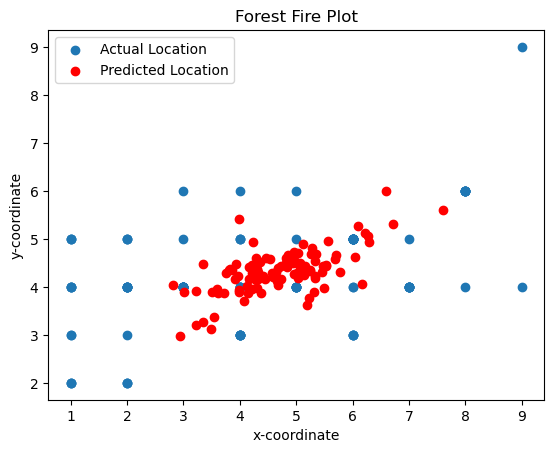

In [76]:
plt.scatter(y_test[:,0], y_test[:,1])
plt.scatter(y_pred[:,0], y_pred[:,1], color = 'red')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Forest Fire Plot')
plt.legend(["Actual Location", "Predicted Location"])

Last, but not least, we try Support Vector Regression. The only problem is that the SVR package in sklearn cannot predict a 2-dimensional continuous variable. So, we will train two regressors for each coordinate, x and y, respectively.

In [47]:
y_train1 = y_train.iloc[:, 0]
y_train2 = y_train.iloc[:, 1]
y_test1 = pd.DataFrame(y_test).iloc[:, 0]
y_test2 = pd.DataFrame(y_test).iloc[:, 1]

In [48]:
regressor1 = SVR(kernel = 'rbf')
regressor2 = SVR(kernel = 'rbf')

In [49]:
regressor1.fit(X_train, y_train1)
regressor2.fit(X_train, y_train2)

SVR()

In [50]:
y_pred1 = regressor1.predict(X_test)
y_pred2 = regressor2.predict(X_test)

In [51]:
y_pred1 = np.expand_dims(y_pred1, axis = 1)
y_pred2 = np.expand_dims(y_pred2, axis = 1)

In [52]:
y_pred = np.concatenate((y_pred1, y_pred2), axis = 1)

In [53]:
sk.metrics.mean_absolute_error(y_test, y_pred)

1.3580455445226984

All three of the models had a significantly smaller mean abosulte error than the SVM model used by Cortez and Morais in their original paper on this dataset from 2007 (https://core.ac.uk/download/pdf/55609027.pdf). On average, the SVR and Random Forest models outperformed the deep learning model. This is likely due to overfitting in the case of the neural network, and the fact that the dataset is small to medium sized, and it is structured data. So, while deep learning methods typically outperform traditional machine learning models for unstructured data (i.e. image processing), that is not the case we observe here.